MIE 1624: A2 - Due: 2023-03-12
- William Hazen
- Student ID: 1009231225

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import probplot
import seaborn as sns

## Purpose: 

- The purpose of this challenge was to “tell a data story about a subset of the data science community represented in this survey, through a combination of both narrative text and data exploration.” 

The dataset provided (kaggle_survey_2022_responses.csv) contains the survey results provided by Kaggle. The survey results from 23997 participants are shown in 296 columns, representing survey questions. Not all  questions  are  answered  by  each  participant, and  responses  contain  various  data  types.  

In  the  dataset, column ‘Q29’ “What  is  your  current  yearly  compensation  (approximate  $USD)?”  contains  the  ordinal categorical target variable. 

The original data (kaggle_survey_2022_responses.csv) has been transformed to clean_kaggle_data_2022.csv as per the code given in KaggleSalary_DataSet.ipynb. 

In the dataset to be used for Assignment 2 (clean_kaggle_data_2022.csv – file to be read in notebook for this Assignment, You should work with the clean dataset for this assignment), rows with the null values of salaries have been dropped. 

In addition, two columns (‘Q29_Encoded’ and ‘Q29_buckets’) have been added at the end. Column ‘Q29_buckets’ (Target Variable for Assignment 2) has been obtained by combining some salary buckets in the column ‘Q29’. Column ‘Q29_Encoded’ has been obtained by label encoding the column ‘Q29_buckets’.

### Notable Questions
- Q29: "Salary"
- Q29_Encoded: "encoded version of Q29" **(Label Encoding)**
- Q29_buckets: "" **(Target Variable)**

- Q2: "Age"
- Q2: "Gender"
- Q4: "Country"
 

# 1. (Data cleaning)

In [4]:
clean_kd = pd.read_csv("clean_kaggle_data_2022.csv", encoding="ISO-8859-1")


In [5]:
clean_kd.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


In [6]:
Q29_bucket = clean_kd["Q29_buckets"].iloc[1:]
Q29_Encoded = clean_kd["Q29_Encoded"].iloc[1:]

In [7]:
clean_kd = clean_kd.drop(['Duration (in seconds)', 'Q29', 'Q29_Encoded', 'Q29_buckets'], axis=1)


### 1.1 Removal of Columns

- According to statistical articles, it is common practice to treat data that has more than 40% missing variables to be considered as hypothesis generating. 
- Therefore if a column has more than 40% missing values, I deemed that column to be dropped

In [8]:
null_column_list = []
column_list = []
for name in clean_kd.columns:
    sum_0 = (clean_kd[name].isna().sum()/len(clean_kd[name]))*100
    #print("{} | {}".format(name, sum_0))

    if sum_0 > 40:
        null_column_list.append(name)
    else:
        column_list.append(name)


In [9]:
len(null_column_list)


276

In [10]:
len(column_list)

18

In [11]:
clean_kd = clean_kd.drop(null_column_list, axis=1)

- I now want to split the data into 2 df since some of the data is multiple choice (MC) and the other is not.
- Generally, if a column has '_' then it is categorical however, columns like Q4 (Countires) are also categorical

In [12]:
mc_list = []
non_mc_list = []
for name in clean_kd.columns:
    if name.find("_") != -1:
        non_mc_list.append(name)
    else:
        mc_list.append(name)

In [13]:
temp_df_mc = clean_kd[[name for name in mc_list]]
temp_non_mc = clean_kd[[name for name in non_mc_list]]


- Some of the MC columns are ordered data meaning that the order to which we encode the data is important, therefore I did analysis on which what columns were ordered 

In [14]:
for name in mc_list:
    print("{} | {}".format(name, temp_df_mc[name].iloc[0]))

Q2 | What is your age (# years)?
Q3 | What is your gender? - Selected Choice
Q4 | In which country do you currently reside?
Q5 | Are you currently a student? (high school, university, or graduate)
Q8 | What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Q9 | Have you ever published any academic research (papers, preprints, conference proceedings, etc)?
Q11 | For how many years have you been writing code and/or programming?
Q16 | For how many years have you used machine learning methods?
Q23 | Select the title most similar to your current role (or most recent title if retired): - Selected Choice
Q24 | In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice
Q25 | What is the size of the company where you are employed?
Q26 | Approximately how many individuals are responsible for data science workloads at your place of business?
Q27 | Does your current employer incorporate ma

### Columns with ordered data
- From the mc_list, Q2, Q11, Q16, Q25, Q26, Q30 appear to have data where the order matters. From here I will encode this data 

In [15]:
ordered_Q = ['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30']
non_ordered_Q = ['Q3', 'Q4', 'Q5', 'Q8', 'Q9', 'Q23', 'Q24', 'Q27']


In [16]:
for name in non_ordered_Q:
    non_mc_list.append(name)
non_mc_list


['Q7_2',
 'Q12_1',
 'Q13_11',
 'Q15_1',
 'Q3',
 'Q4',
 'Q5',
 'Q8',
 'Q9',
 'Q23',
 'Q24',
 'Q27']

In [17]:
df_mc = clean_kd[[name for name in ordered_Q]].iloc[1:]
df_non_mc = clean_kd[[name for name in non_mc_list]].iloc[1:]


### 1.2 Dealing with NaNs in the ordered MC DF

In [18]:
for name in df_mc.columns:
    if df_mc[name].isna().sum() > 0:
        df_mc[name].fillna(df_mc[name].mode()[0], inplace=True) #replaced nans with the most common values in the column


for name in df_non_mc.columns:
    if df_non_mc[name].isna().sum() > 0:
        #df_non_mc[name].fillna(df_non_mc[name].mode()[0], inplace=True)
        df_non_mc[name].fillna("unknown", inplace=True)
        
        
"""
I found that when replace df_non_mc columns that have NaNs with mode, some columns get entirely replaced with 1's when applying get_dummies thus I filled na with 'unknown'
"""


"\nI found that when replace df_non_mc columns that have NaNs with mode, some columns get entirely replaced with 1's when applying get_dummies thus I filled na with 'unknown'\n"

In [19]:
df_mc[0:3]

,Q2,Q11,Q16,Q25,Q26,Q30
1,55-59,10-20 years,1-2 years,0-49 employees,2-Jan,"$1000-$9,999"
2,30-34,10-20 years,4-5 years,250-999 employees,20+,$0 ($USD)
3,70+,20+ years,5-10 years,"1000-9,999 employees",20+,$100-$999


In [20]:
df_non_mc[0:3]


,Q7_2,Q12_1,Q13_11,Q15_1,Q3,Q4,Q5,Q8,Q9,Q23,Q24,Q27
1,"Online courses (Coursera, EdX, etc)",Python,Jupyter Notebook,Matplotlib,Man,France,No,Some college/university study without earning ...,unknown,Data Scientist,Online Service/Internet-based Services,"We recently started using ML methods (i.e., mo..."
2,"Online courses (Coursera, EdX, etc)",Python,Jupyter Notebook,Matplotlib,Man,Germany,No,BachelorEEs degree,unknown,Software Engineer,Insurance/Risk Assessment,"We have well established ML methods (i.e., mod..."
3,unknown,Python,Jupyter Notebook,unknown,Man,Australia,No,Doctoral degree,Yes,Research Scientist,Government/Public Service,"We recently started using ML methods (i.e., mo..."


### 1.3 Encoding
- Used SKLearn OrdinalEncoder to encode MC data

In [21]:
for name in ordered_Q:
    print("{} | {}".format(name, temp_df_mc[name].iloc[0]))


Q2 | What is your age (# years)?
Q11 | For how many years have you been writing code and/or programming?
Q16 | For how many years have you used machine learning methods?
Q25 | What is the size of the company where you are employed?
Q26 | Approximately how many individuals are responsible for data science workloads at your place of business?
Q30 | Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?
 (approximate $USD)?


In [22]:
for name in ordered_Q:
    print(name)
    print(df_mc[name].value_counts())
    print()

Q2
25-29    1604
30-34    1430
35-39    1207
40-44    1037
22-24     743
45-49     701
50-54     567
55-59     359
60-69     341
18-21      83
70+        64
Name: Q2, dtype: int64

Q11
1-3 years                    1468
5-10 years                   1394
3-5 years                    1243
10-20 years                  1155
< 1 years                    1148
20+ years                    1044
I have never written code     684
Name: Q11, dtype: int64

Q16
Under 1 year                             2408
1-2 years                                1266
I do not use machine learning methods    1107
2-3 years                                 955
5-10 years                                808
4-5 years                                 635
3-4 years                                 591
10-20 years                               366
Name: Q16, dtype: int64

Q25
10,000 or more employees    1914
0-49 employees              1859
1000-9,999 employees        1711
50-249 employees            1429
250-999 employees  

In [23]:
df_mc['Q2'].value_counts()


25-29    1604
30-34    1430
35-39    1207
40-44    1037
22-24     743
45-49     701
50-54     567
55-59     359
60-69     341
18-21      83
70+        64
Name: Q2, dtype: int64

In [24]:
ages = ['18-21', '22-24', '25-29', '30-34', '35-39',
        '40-44', '45-49', '50-54', '55-59', '60-69', '70+']
Q2_E = OrdinalEncoder(categories=[ages])
df_mc['Q2'] = Q2_E.fit_transform(df_mc[['Q2']])


In [25]:
df_mc['Q2'].value_counts()


2.0     1604
3.0     1430
4.0     1207
5.0     1037
1.0      743
6.0      701
7.0      567
8.0      359
9.0      341
0.0       83
10.0      64
Name: Q2, dtype: int64

In [26]:
q11 = ["I have never written code", "< 1 years", "1-3 years", "3-5 years", '5-10 years', '10-20 years', '20+ years']
Q11_E = OrdinalEncoder(categories=[q11])
df_mc['Q11'] = Q11_E.fit_transform(df_mc[['Q11']])


In [27]:
q16 = ["I do not use machine learning methods", "Under 1 year", "1-2 years", "2-3 years", "3-4 years", '4-5 years', '5-10 years', '10-20 years']
Q16_E = OrdinalEncoder(categories=[q16])
df_mc['Q16'] = Q16_E.fit_transform(df_mc[['Q16']])


In [28]:
q25 = ["0-49 employees", "50-249 employees",
       "250-999 employees", "1000-9,999 employees", "10,000 or more employees"]
Q25_E = OrdinalEncoder(categories=[q25])
df_mc['Q25'] = Q25_E.fit_transform(df_mc[['Q25']])


In [29]:
q26 = ["0", "2-Jan", "4-Mar", "9-May", "14-Oct", "15-19", "20+"]
Q26_E = OrdinalEncoder(categories=[q26])
df_mc['Q26'] = Q26_E.fit_transform(df_mc[['Q26']])


In [30]:
q30 = ["$0 ($USD)", "$1-$99", "$100-$999", "$1000-$9,999", "$10,000-$99,999", "$100,000 or more ($USD)"]
Q30_E = OrdinalEncoder(categories=[q30])
df_mc['Q30'] = Q30_E.fit_transform(df_mc[['Q30']])


In [31]:
df_mc


,Q2,Q11,Q16,Q25,Q26,Q30
1,8.0,5.0,2.0,0.0,1.0,3.0
2,3.0,5.0,5.0,2.0,6.0,0.0
3,10.0,6.0,6.0,3.0,6.0,2.0
4,5.0,5.0,6.0,3.0,6.0,2.0
5,5.0,5.0,6.0,3.0,2.0,5.0
...,...,...,...,...,...,...
8132,5.0,5.0,1.0,4.0,6.0,0.0
8133,4.0,2.0,2.0,4.0,1.0,2.0
8134,5.0,2.0,0.0,0.0,0.0,1.0
8135,2.0,1.0,1.0,4.0,0.0,2.0


In [32]:
df_non_mc_temp = pd.get_dummies(df_non_mc, columns=[name for name in df_non_mc.columns])
df_non_mc_temp


,"Q7_2_Online courses (Coursera, EdX, etc)",Q7_2_unknown,Q12_1_Python,Q12_1_unknown,Q13_11_ Jupyter Notebook,Q13_11_unknown,Q15_1_ Matplotlib,Q15_1_unknown,Q3_Man,Q3_Nonbinary,...,Q24_Online Service/Internet-based Services,Q24_Other,Q24_Retail/Sales,Q24_Shipping/Transportation,Q27_I do not know,Q27_No (we do not use ML methods),Q27_We are exploring ML methods (and may one day put a model into production),"Q27_We have well established ML methods (i.e., models in production for more than 2 years)","Q27_We recently started using ML methods (i.e., models in production for less than 2 years)",Q27_We use ML methods for generating insights (but do not put working models into production)
1,1,0,1,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
5,0,1,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8133,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8134,1,0,1,0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8135,1,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [33]:
df_non_mc_temp = df_non_mc_temp.drop(["Q5_No"], axis=1)


### 1.4 Merge

In [34]:
clean_df = pd.concat([df_mc, df_non_mc_temp], axis=1)
#clean_df = clean_df.sort_index(axis=1)
clean_df

,Q2,Q11,Q16,Q25,Q26,Q30,"Q7_2_Online courses (Coursera, EdX, etc)",Q7_2_unknown,Q12_1_Python,Q12_1_unknown,...,Q24_Online Service/Internet-based Services,Q24_Other,Q24_Retail/Sales,Q24_Shipping/Transportation,Q27_I do not know,Q27_No (we do not use ML methods),Q27_We are exploring ML methods (and may one day put a model into production),"Q27_We have well established ML methods (i.e., models in production for more than 2 years)","Q27_We recently started using ML methods (i.e., models in production for less than 2 years)",Q27_We use ML methods for generating insights (but do not put working models into production)
1,8.0,5.0,2.0,0.0,1.0,3.0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,5.0,5.0,2.0,6.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,10.0,6.0,6.0,3.0,6.0,2.0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,5.0,5.0,6.0,3.0,6.0,2.0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,5.0,5.0,6.0,3.0,2.0,5.0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,5.0,5.0,1.0,4.0,6.0,0.0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8133,4.0,2.0,2.0,4.0,1.0,2.0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8134,5.0,2.0,0.0,0.0,0.0,1.0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8135,2.0,1.0,1.0,4.0,0.0,2.0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [35]:
#drop columns that have a high percentage of 0's
null_column_list = []
column_list = []
for name in clean_df.columns:
    num_responses = len(clean_df[name])
    num_zeros = clean_df[name].value_counts().get(0, 0)
    percent_zeros = num_zeros / num_responses * 100
    #print("{} | {}".format(name, percent_zeros))

    if percent_zeros > 95:
        null_column_list.append(name)  
    elif name[-5:] == "Other":
        null_column_list.append(name)
    elif name[-7:] == "unknown":
        null_column_list.append(name)
    else:
        column_list.append(name)


In [36]:
clean_df = clean_df.drop(columns=null_column_list)
clean_df


,Q2,Q11,Q16,Q25,Q26,Q30,"Q7_2_Online courses (Coursera, EdX, etc)",Q12_1_Python,Q13_11_ Jupyter Notebook,Q15_1_ Matplotlib,...,Q24_Government/Public Service,Q24_Manufacturing/Fabrication,Q24_Medical/Pharmaceutical,Q24_Online Service/Internet-based Services,Q27_I do not know,Q27_No (we do not use ML methods),Q27_We are exploring ML methods (and may one day put a model into production),"Q27_We have well established ML methods (i.e., models in production for more than 2 years)","Q27_We recently started using ML methods (i.e., models in production for less than 2 years)",Q27_We use ML methods for generating insights (but do not put working models into production)
1,8.0,5.0,2.0,0.0,1.0,3.0,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
2,3.0,5.0,5.0,2.0,6.0,0.0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,10.0,6.0,6.0,3.0,6.0,2.0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
4,5.0,5.0,6.0,3.0,6.0,2.0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
5,5.0,5.0,6.0,3.0,2.0,5.0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,5.0,5.0,1.0,4.0,6.0,0.0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
8133,4.0,2.0,2.0,4.0,1.0,2.0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
8134,5.0,2.0,0.0,0.0,0.0,1.0,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
8135,2.0,1.0,1.0,4.0,0.0,2.0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [37]:
clean_encoded = pd.concat([clean_df, Q29_Encoded], axis=1)

# 2. (Exploratory data analysis and feature selection)

- Feature engineering is very important in the context of machine learning. 

### 2.1 Correlation Matrix

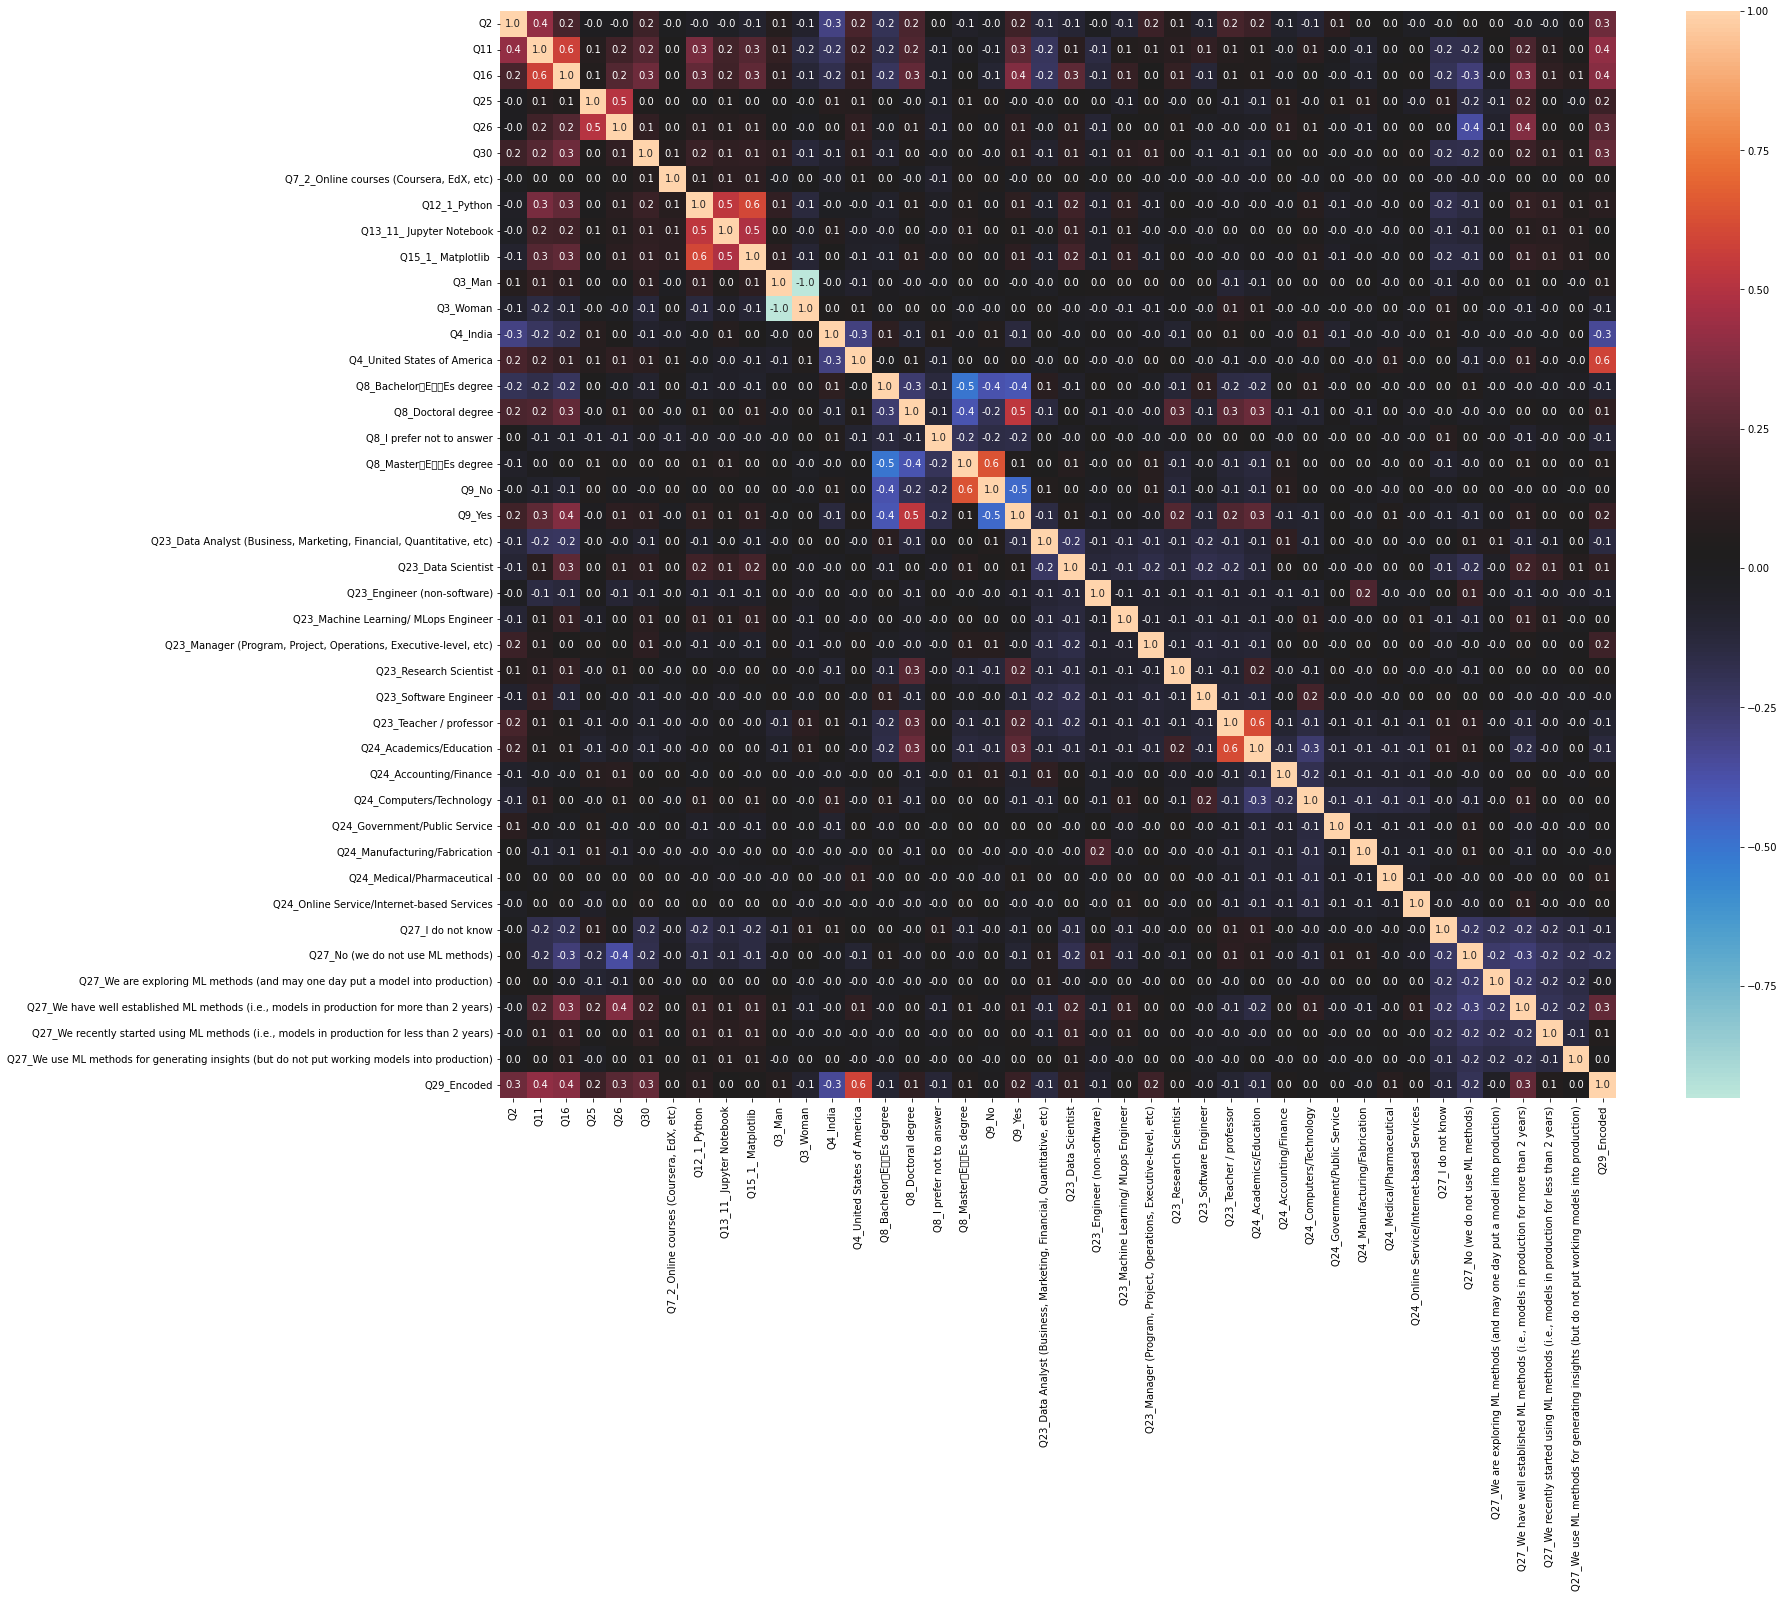

In [38]:
""" 
Apply a correlation matrix just to have a high level overview of what features are correlated with Q29_29
"""

# Correlation Heatmap 
cor_matrix = clean_encoded.corr()
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(cor_matrix, annot=True, fmt='.1f', cmap='icefire')
plt.show()

In [39]:
cor_matrix.head()

,Q2,Q11,Q16,Q25,Q26,Q30,"Q7_2_Online courses (Coursera, EdX, etc)",Q12_1_Python,Q13_11_ Jupyter Notebook,Q15_1_ Matplotlib,...,Q24_Manufacturing/Fabrication,Q24_Medical/Pharmaceutical,Q24_Online Service/Internet-based Services,Q27_I do not know,Q27_No (we do not use ML methods),Q27_We are exploring ML methods (and may one day put a model into production),"Q27_We have well established ML methods (i.e., models in production for more than 2 years)","Q27_We recently started using ML methods (i.e., models in production for less than 2 years)",Q27_We use ML methods for generating insights (but do not put working models into production),Q29_Encoded
Q2,1.000000,0.413829,0.212943,-0.001037,-0.004270,0.172469,-0.008876,-0.040253,-0.032614,-0.075293,...,0.021290,0.017338,-0.036068,-0.008905,0.032662,0.034946,-0.030572,-0.035104,0.002385,0.315812
Q11,0.413829,1.000000,0.575806,0.075332,0.178416,0.247660,0.029823,0.346370,0.190868,0.253027,...,-0.082423,0.006432,0.027202,-0.175066,-0.179218,0.022231,0.221689,0.087139,0.033801,0.406746
Q16,0.212943,0.575806,1.000000,0.055627,0.241637,0.321053,0.027450,0.287257,0.181095,0.282982,...,-0.061199,0.021770,0.039044,-0.202686,-0.275108,-0.043336,0.346557,0.116395,0.081689,0.385459
Q25,-0.001037,0.075332,0.055627,1.000000,0.508234,0.042745,0.029271,0.010671,0.052155,0.013981,...,0.071127,0.010782,-0.044366,0.087567,-0.155849,-0.089965,0.182600,0.011265,-0.031683,0.165711
Q26,-0.004270,0.178416,0.241637,0.508234,1.000000,0.128094,0.040705,0.085634,0.071861,0.093621,...,-0.055977,0.010133,0.030657,0.002246,-0.358136,-0.071169,0.373296,0.046068,0.031677,0.255693


In [40]:
"""
Top 10 correlated Features 
"""
cor_matrix.Q29_Encoded.sort_values(ascending=False)[0:10]

Q29_Encoded                                                                                   1.000000
Q4_United States of America                                                                   0.584453
Q11                                                                                           0.406746
Q16                                                                                           0.385459
Q2                                                                                            0.315812
Q30                                                                                           0.297743
Q27_We have well established ML methods (i.e., models in production for more than 2 years)    0.286738
Q26                                                                                           0.255693
Q23_Manager (Program, Project, Operations, Executive-level, etc)                              0.171829
Q25                                                                      

In [41]:
"""
Bottom 10 correlated Features 
"""
cor_matrix.Q29_Encoded.sort_values(ascending=False)[-10:]


Q23_Engineer (non-software)                                            -0.073533
Q3_Woman                                                               -0.078973
Q8_BachelorEEs degree                                               -0.092898
Q23_Teacher / professor                                                -0.096139
Q8_I prefer not to answer                                              -0.109180
Q27_I do not know                                                      -0.116102
Q24_Academics/Education                                                -0.130247
Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)   -0.139196
Q27_No (we do not use ML methods)                                      -0.198602
Q4_India                                                               -0.339819
Name: Q29_Encoded, dtype: float64

### 2.2 Chi2 Test

In [42]:
""" 
chi^2 test to see pvalues of features
"""

X, y = clean_df, Q29_Encoded

scores, pvalues = chi2(X, y)
pvalue_df = pd.Series(pvalues, index=X.columns)
pvalue_df = pvalue_df.sort_values(ascending=False) 

pvalue_df[0:20]

# We can see that there Q13_11_Jupter Notebook has a high p value so the null hypothesis can be rejected


Q13_11_ Jupyter Notebook                                                                         7.444496e-01
Q9_No                                                                                            4.494931e-01
Q3_Man                                                                                           3.804210e-01
Q27_We use ML methods for generating insights (but do not put working models into production)    3.151049e-01
Q12_1_Python                                                                                     2.098118e-01
Q23_Software Engineer                                                                            1.703576e-01
Q7_2_Online courses (Coursera, EdX, etc)                                                         1.558376e-01
Q23_Machine Learning/ MLops Engineer                                                             5.974403e-02
Q15_1_ Matplotlib                                                                                4.451591e-02
Q27_We are

### 2.3 Regularized Regression

References:
- https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html
- https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
- https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499


In [43]:
x_temp = X.copy()
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(x_temp), columns=X.columns)

In [44]:
# Modified from Tutorial 5 Logistic_Regression.ipynb
model = Lasso()
best_model = model
best_params = {}
best_score = 0
best_std = 0


alpha_list = [0.1, 0.2, 0.5, 1, 2, 5, 10]
for alpha in alpha_list:

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_std, y)

    importance_features = lasso.coef_
    score = lasso.score(X_std, y)

    if score > best_score:
        best_model = model
        best_params = {'alpha': alpha}
        best_score = score
        best_std = np.std(score)

print(best_params)
print("Best Score: {}%({}%)".format(round(best_score, 3), round(best_std, 3)))
print("\nThe optimal log model uses C={}, and has a score of {}% with a standard deviation of {}%".format(best_params['alpha'], round(best_score, 3), round(best_std, 3)))



{'alpha': 0.1}
Best Score: 0.55%(0.0%)

The optimal log model uses C=0.1, and has a score of 0.55% with a standard deviation of 0.0%


In [45]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
#   - alpha was advised not to be 0 -> 0.1 was used as example.

lasso = Lasso(alpha=0.1)
lasso.fit(X_std, y)

importance_features = lasso.coef_
print(lasso.score(X_std, y))

Good_features = np.array(X.columns)[importance_features > 0]
Bad_features = np.array(X.columns)[importance_features <= 0]
print(len(Good_features))
print(len(Bad_features))


0.5498090686417649
13
28


In [46]:
Good_features

array(['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q3_Man',
       'Q4_United States of America', 'Q9_Yes', 'Q23_Data Scientist',
       'Q23_Manager (Program, Project, Operations, Executive-level, etc)',
       'Q24_Accounting/Finance',
       'Q27_We have well established ML methods (i.e., models in production for more than 2 years)'],
      dtype=object)

In [47]:
Good_features

array(['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q3_Man',
       'Q4_United States of America', 'Q9_Yes', 'Q23_Data Scientist',
       'Q23_Manager (Program, Project, Operations, Executive-level, etc)',
       'Q24_Accounting/Finance',
       'Q27_We have well established ML methods (i.e., models in production for more than 2 years)'],
      dtype=object)

In [48]:
Bad_features

array(['Q7_2_Online courses (Coursera, EdX, etc)', 'Q12_1_Python',
       'Q13_11_ Jupyter Notebook', 'Q15_1_ Matplotlib ', 'Q3_Woman',
       'Q4_India', 'Q8_Bachelor\x81E\x80\x81Es degree',
       'Q8_Doctoral degree', 'Q8_I prefer not to answer',
       'Q8_Master\x81E\x80\x81Es degree', 'Q9_No',
       'Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)',
       'Q23_Engineer (non-software)',
       'Q23_Machine Learning/ MLops Engineer', 'Q23_Research Scientist',
       'Q23_Software Engineer', 'Q23_Teacher / professor',
       'Q24_Academics/Education', 'Q24_Computers/Technology',
       'Q24_Government/Public Service', 'Q24_Manufacturing/Fabrication',
       'Q24_Medical/Pharmaceutical',
       'Q24_Online Service/Internet-based Services', 'Q27_I do not know',
       'Q27_No (we do not use ML methods)',
       'Q27_We are exploring ML methods (and may one day put a model into production)',
       'Q27_We recently started using ML methods (i.e., models in produc

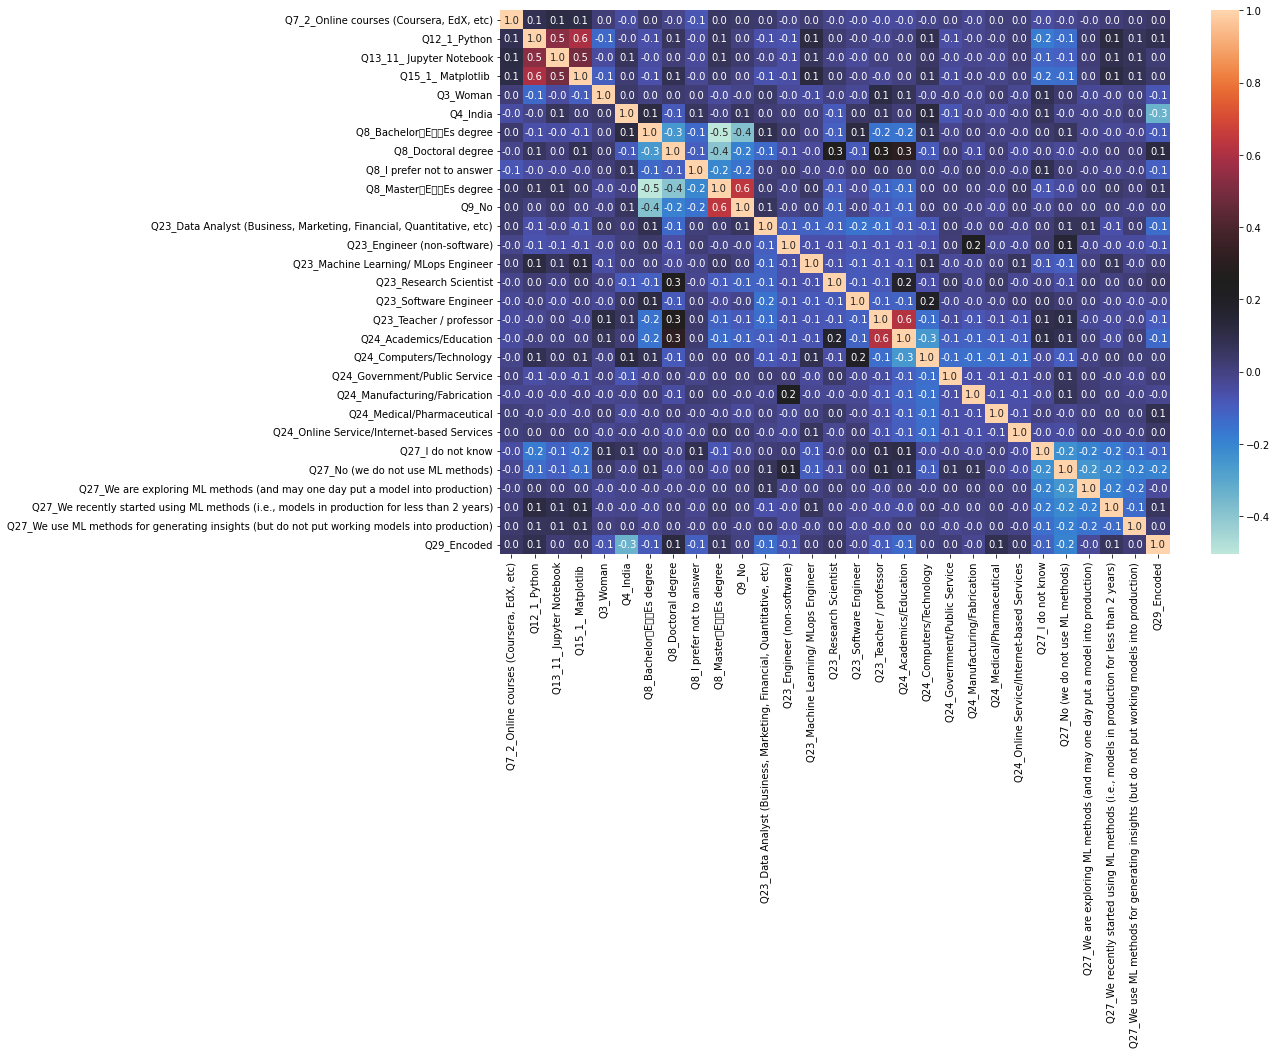

In [49]:
""" 
Bad Features
"""
bad_clean_df = clean_df.drop(Good_features, axis=1)

# Correlation Heatmap
bad_clean_df_q29 = pd.concat([bad_clean_df, Q29_Encoded], axis=1)
bad_clean_matrix = bad_clean_df_q29.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(bad_clean_matrix, annot=True, fmt='.1f', cmap='icefire')
plt.show()


In [50]:
bad_clean_matrix.Q29_Encoded.sort_values(ascending=False)[0:5]


Q29_Encoded                                                                                    1.000000
Q8_Doctoral degree                                                                             0.118267
Q12_1_Python                                                                                   0.086176
Q24_Medical/Pharmaceutical                                                                     0.083790
Q27_We recently started using ML methods (i.e., models in production for less than 2 years)    0.055192
Name: Q29_Encoded, dtype: float64

In [51]:
bad_clean_matrix.Q29_Encoded.sort_values(ascending=True)[0:5]


Q4_India                                                               -0.339819
Q27_No (we do not use ML methods)                                      -0.198602
Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)   -0.139196
Q24_Academics/Education                                                -0.130247
Q27_I do not know                                                      -0.116102
Name: Q29_Encoded, dtype: float64

In [52]:
core_clean_df = clean_df.drop(Bad_features, axis=1)
core_clean_df

,Q2,Q11,Q16,Q25,Q26,Q30,Q3_Man,Q4_United States of America,Q9_Yes,Q23_Data Scientist,"Q23_Manager (Program, Project, Operations, Executive-level, etc)",Q24_Accounting/Finance,"Q27_We have well established ML methods (i.e., models in production for more than 2 years)"
1,8.0,5.0,2.0,0.0,1.0,3.0,1,0,0,1,0,0,0
2,3.0,5.0,5.0,2.0,6.0,0.0,1,0,0,0,0,0,1
3,10.0,6.0,6.0,3.0,6.0,2.0,1,0,1,0,0,0,0
4,5.0,5.0,6.0,3.0,6.0,2.0,1,1,1,0,0,0,1
5,5.0,5.0,6.0,3.0,2.0,5.0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,5.0,5.0,1.0,4.0,6.0,0.0,1,1,0,0,0,1,1
8133,4.0,2.0,2.0,4.0,1.0,2.0,1,0,0,1,0,0,1
8134,5.0,2.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0
8135,2.0,1.0,1.0,4.0,0.0,2.0,1,0,1,0,0,0,0


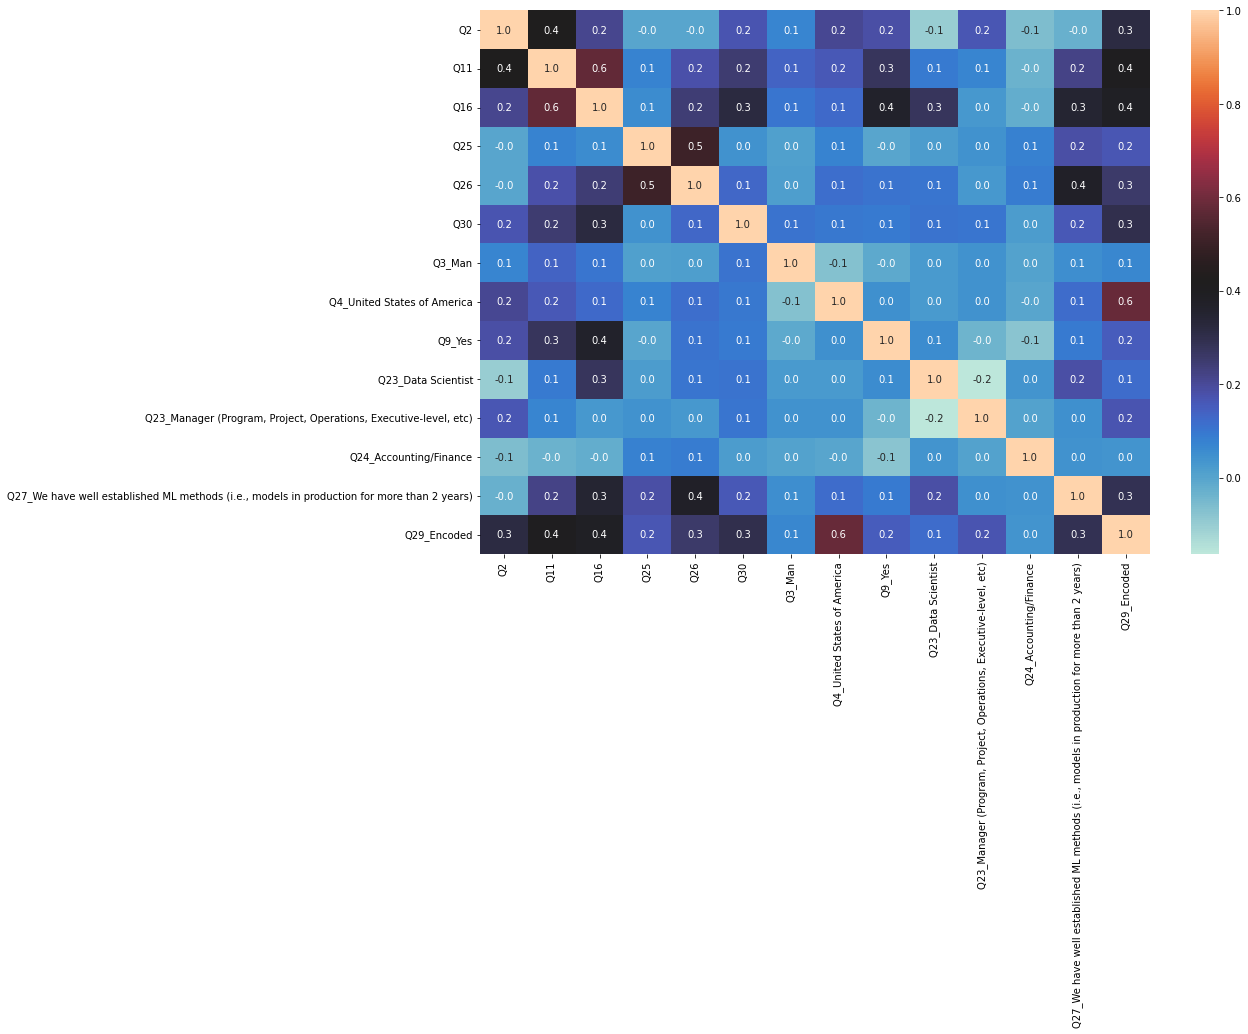

In [53]:
""" 
Good Features
"""
# Correlation Heatmap
core_clean_df_q29 = pd.concat([core_clean_df, Q29_Encoded], axis=1)
cor_clean_matrix = core_clean_df_q29.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cor_clean_matrix, annot=True, fmt='.1f', cmap='icefire')
plt.show()


In [54]:
corplot = cor_clean_matrix.Q29_Encoded.sort_values(ascending=True)
corplot


Q24_Accounting/Finance                                                                        0.040357
Q3_Man                                                                                        0.064562
Q23_Data Scientist                                                                            0.121645
Q9_Yes                                                                                        0.152695
Q25                                                                                           0.165711
Q23_Manager (Program, Project, Operations, Executive-level, etc)                              0.171829
Q26                                                                                           0.255693
Q27_We have well established ML methods (i.e., models in production for more than 2 years)    0.286738
Q30                                                                                           0.297743
Q2                                                                       

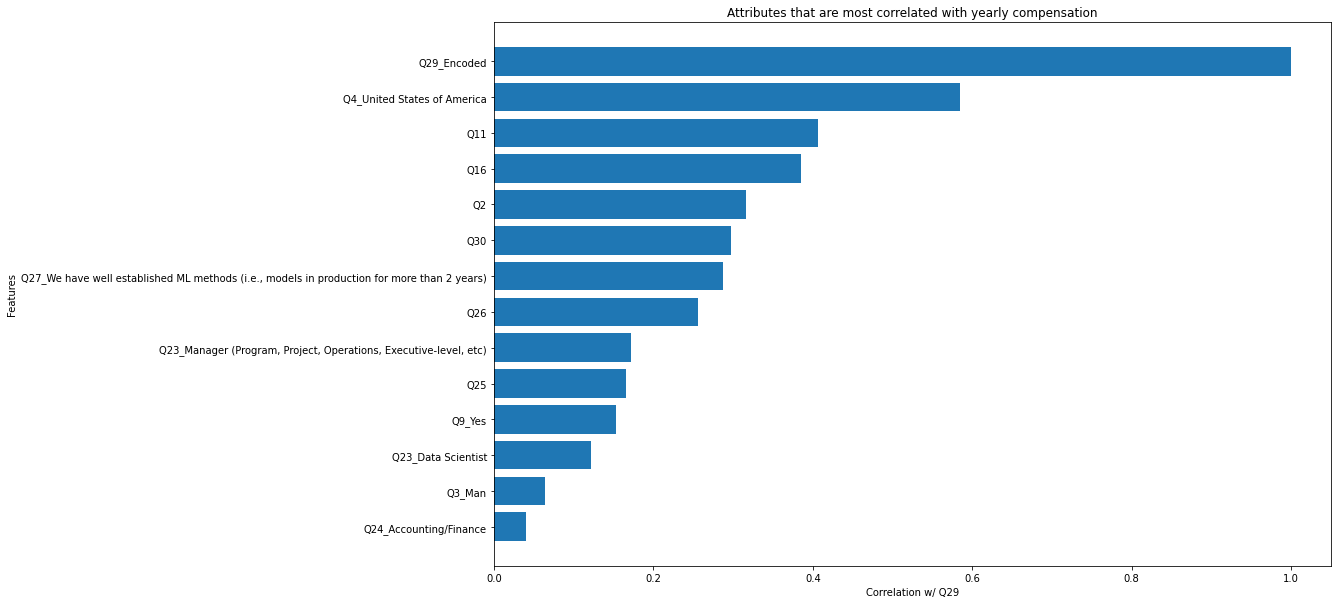

In [55]:
plt.figure(figsize=(15,10))
plt.barh(corplot.index, corplot.values)
plt.ylabel("Features")
plt.xlabel('Correlation w/ Q29')
plt.title("Attributes that are most correlated with yearly compensation")
plt.show()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(core_clean_df, y, test_size=0.25, random_state=71)

scaler = StandardScaler()
X_fit = scaler.fit(X_train)

X_train_std = pd.DataFrame(X_fit.transform(X_train), columns=core_clean_df.columns)
X_test_std = pd.DataFrame(X_fit.transform(X_test), columns=core_clean_df.columns)

- Using Lasso regularization we were able to extract 13 core features and discard the remaining 28 features. Additionally, from the visual exploration with correlation matrix's I was able to see which features are correlated with Q29 in a sorted fashion.
- Thus the number of features that will be used for future work is 13. 

# 3. (Model implementation)

References:
- https://www.kaggle.com/code/ronennakash/ordinal-logistic-regression-solution
- Tutorial 5 Logistic_Regression.ipynb


In [58]:
X_train_c = X_train.copy()
y_train_c = y_train.copy()

X_test_c= X_test.copy()
y_test_c= y_test.copy()


In [59]:
len(y_train_c.value_counts())

15

In [60]:
def OLR(x_train, y_train, x_test, model):

    probability_list = []
    previous_class = 0
    coefficent_list = []

    for i in range(0, 14):  # loop through classes 0 - 13 doing a binary classification
        I = (y_train > i).astype(int)  # vectoried indicator function
        model.fit(x_train, I)  # fit model
        current_class = model.predict_proba(x_test)[:, 0]  # probabilities predictions
        # distinguish between the current class and all previous classes
        probability_list.append(current_class - previous_class)
        previous_class = current_class  # set previous class as current class
        coefficent_list.append(model.coef_)  # store model coefficents

    p_pred_14 = model.predict_proba(x_test)[:, 1]
    probability_list.append(p_pred_14)

    best_prob = np.argmax(probability_list, axis=0)
    coef_list_avg = np.mean(coefficent_list, axis=0)
    
    return best_prob, coef_list_avg


In [61]:
# Modified from Tutorial 5 Logistic_Regression.ipynb

model = LogisticRegression(random_state=71)
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_c)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, val_idx in kfold.split(X_train_c):
    X_train_k, X_val_k = X_train_c.values[train_idx], X_train_c.values[val_idx]
    y_train_k, y_val_k = y_train_c.values[train_idx], y_train_c.values[val_idx]
    
    predictions, coef_list = OLR(X_train_k, y_train_k, X_val_k, model)
    
    ACC = accuracy_score(y_val_k, predictions)*100
    accuracy[np_idx] = ACC
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   
print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 44.026%
Fold 2: Accuracy: 42.39%
Fold 3: Accuracy: 42.295%
Fold 4: Accuracy: 39.672%
Fold 5: Accuracy: 40.164%
Fold 6: Accuracy: 41.148%
Fold 7: Accuracy: 45.082%
Fold 8: Accuracy: 39.344%
Fold 9: Accuracy: 39.508%
Fold 10: Accuracy: 40.0%
Average Score: 41.363%(1.912%)


In [62]:
# Modified from Tutorial 5 Logistic_Regression.ipynb

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0
bias_list = []
variance_list = []
MSE_list = []
Total_Error_list = []
c_list = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
for C in c_list:
    model = LogisticRegression(C=C, random_state=71)
    accuracy = np.zeros(10)
    MSE = []
    total_error = []
    bias = []
    variance = []
    np_idx = 0
    
    for train_idx, val_idx in kfold.split(X_train_c):
        X_train_k, X_val_k = X_train_c.values[train_idx], X_train_c.values[val_idx]
        y_train_k, y_val_k = y_train_c.values[train_idx], y_train_c.values[val_idx]

        predictions, coef_list = OLR(X_train_k, y_train_k, X_val_k, model)
        
        accuracy[np_idx] = accuracy_score(y_val_k, predictions)*100
        
        bias.append(np.mean((predictions - y_val_k)**2))
        variance.append(np.mean((np.mean(predictions) - predictions)**2))
        MSE.append(bias[-1] + variance[-1])
        
        np_idx += 1 
    
    bias_list.append(np.mean(bias))
    variance_list.append(np.mean(variance))
    MSE_list.append(np.mean(MSE))    
    
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      
print ("\nThe optimal log model uses C={}, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],round(best_accuracy,3),round(best_std,3)))
print()
print("Bias", bias_list)
print("Variance", variance_list)

{'C': 0.1}
Best Score: 41.478%(1.922%)

The optimal log model uses C=0.1, and has a cross validation score of 41.478% with a standard deviation of 1.922%

Bias [26.382725979984436, 19.191264253709317, 15.91118725014086, 15.301473531700248, 14.836712189101444, 14.836563816371978, 14.80461806766655, 14.790519438705697, 14.794627190040515]
Variance [11.881821525278616, 16.849106242314882, 19.113885300874276, 19.554149759269638, 20.13092413391969, 20.188178855798732, 20.247652122906267, 20.242511061468548, 20.262603269341074]


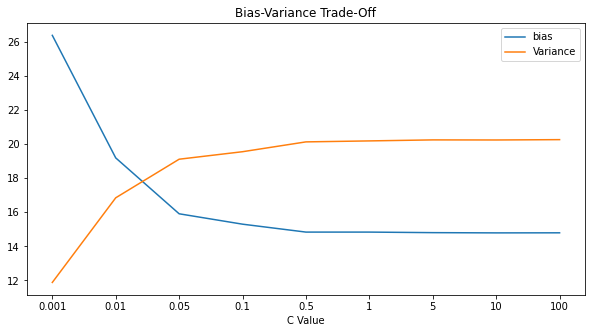

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(bias_list, label='bias')
plt.plot(variance_list,  label='Variance')
plt.xlabel('C Value')
plt.xticks(range(len(c_list)), c_list)
plt.title('Bias-Variance Trade-Off')
plt.legend()
plt.show()

# 4. (Model tuning)

In [64]:
""" 
All the Hyperparameters in the logisticRegression model
    penalty: str = "l2",
    *,
    dual: bool = False,
    tol: float = 0.0001,
    C: float = 1,
    fit_intercept: bool = True,
    intercept_scaling: int = 1,
    class_weight: Unknown | None = None,
    random_state: Unknown | None = None,
    solver: str = "lbfgs",
    max_iter: int = 100,
    multi_class: str = "auto",
    verbose: int = 0,
    warm_start: bool = False,
    n_jobs: Unknown | None = None,
    l1_ratio: Unknown | None = None

"""

# Modified from Tutorial 5 Logistic_Regression.ipynb

model = LogisticRegression(random_state=71)
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_c)

best_model = model
best_params = {}
best_f1 = 0
best_std = 0

for C in c_list:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        model = LogisticRegression(C=C, solver=solver, random_state=71)
        f1 = np.zeros(10)
        np_idx = 0
        coefficent_list = []
        
        for train_idx, val_idx in kfold.split(X_train_c):
            X_train_k, X_val_k = X_train_c.values[train_idx], X_train_c.values[val_idx]
            y_train_k, y_val_k = y_train_c.values[train_idx], y_train_c.values[val_idx]

            predictions, coef_list = OLR(X_train_k, y_train_k, X_val_k, model)
            coefficent_list.append(coef_list)
            
            accuracy[np_idx] = accuracy_score(y_val_k, predictions)*100
            f1[np_idx] = f1_score(y_val_k, predictions, average='macro') 
            np_idx += 1
            

        if np.mean(f1) > best_f1:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_f1 = np.mean(f1)
            best_std = np.std(f1)
            
print (best_params)
print ("Best Score: {}%({}%)".format(round(best_f1,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_f1,3),round(best_std,3)))

{'C': 100, 'solver': 'liblinear'}
Best Score: 0.124%(0.015%)

The optimal log model uses C=100, and a liblinear solver, and has a cross validation score of 0.124% with a standard deviation of 0.015%


In [65]:

# Modified from Tutorial 5 Logistic_Regression.ipynb
model = LogisticRegression(random_state=71)
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_c)

model = LogisticRegression(C=100, solver='liblinear', random_state=71)
f1 = np.zeros(10)
np_idx = 0
coefficent_list = []

for train_idx, val_idx in kfold.split(X_train_c):
    X_train_k, X_val_k = X_train_c.values[train_idx], X_train_c.values[val_idx]
    y_train_k, y_val_k = y_train_c.values[train_idx], y_train_c.values[val_idx]

    predictions, coef_list = OLR(X_train_k, y_train_k, X_val_k, model)
    
    f1[np_idx] = f1_score(y_val_k, predictions, average='macro')
    np_idx += 1
    coefficent_list.append(coef_list) #average the coef from the 10-cross folds

In [66]:
importance_f1 = np.mean(coefficent_list, axis=0)
importance_f1 = pd.DataFrame(importance_f1, columns=core_clean_df.columns)
sorted_imp = importance_f1.iloc[0].sort_values(ascending=True)
sorted_imp

Q25                                                                                           0.084141
Q26                                                                                           0.093201
Q2                                                                                            0.101974
Q9_Yes                                                                                        0.105908
Q16                                                                                           0.132802
Q11                                                                                           0.211245
Q30                                                                                           0.274566
Q3_Man                                                                                        0.305685
Q23_Data Scientist                                                                            0.325404
Q24_Accounting/Finance                                                   

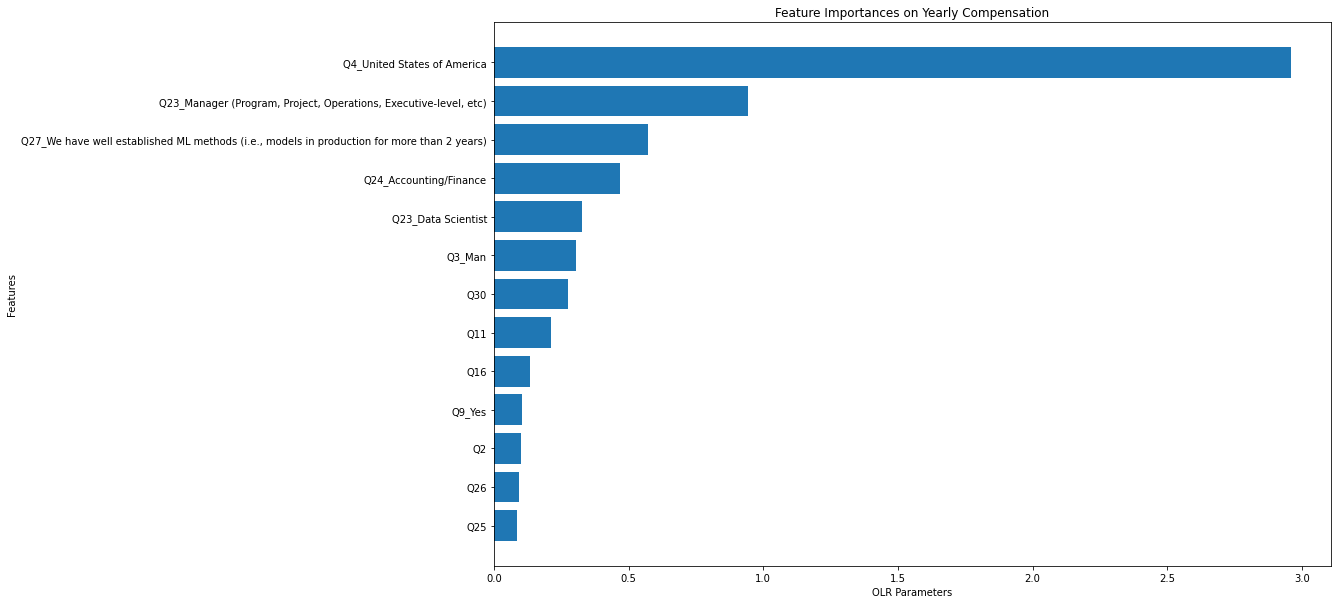

In [67]:
plt.figure(figsize=(15,10))
plt.barh(sorted_imp.index, sorted_imp.tolist())
plt.ylabel("Features")
plt.xlabel('OLR Parameters')
plt.title("Feature Importances on Yearly Compensation")
plt.show()

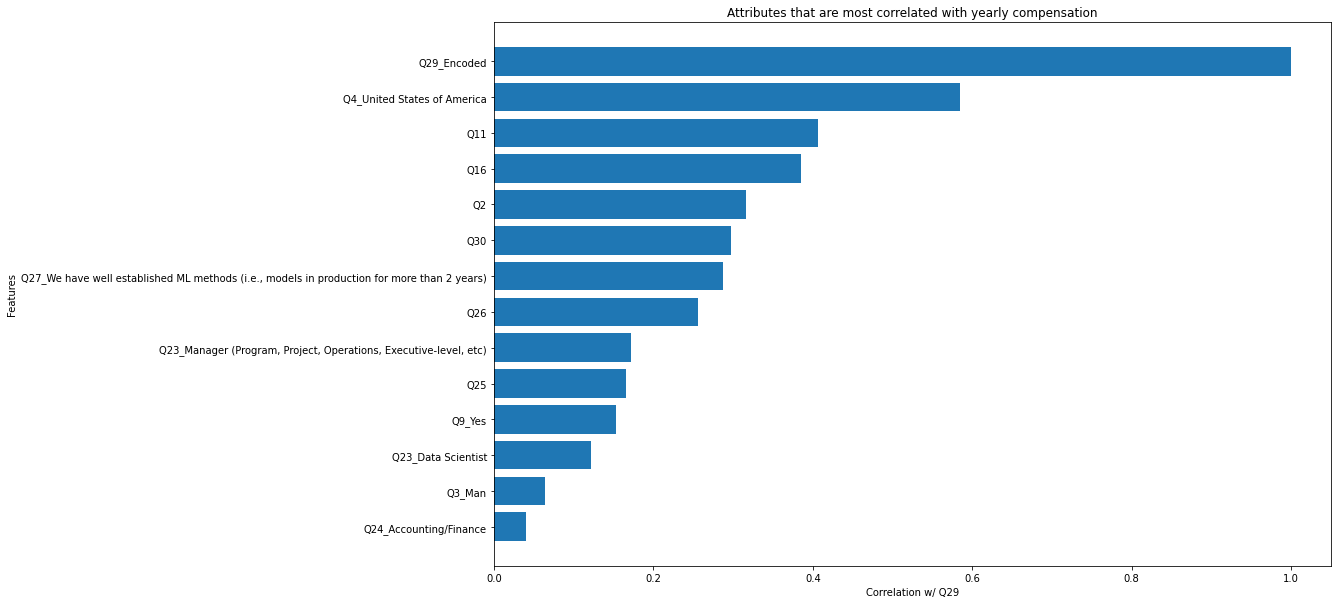

In [68]:
plt.figure(figsize=(15, 10))
plt.barh(corplot.index, corplot.values)
plt.ylabel("Features")
plt.xlabel('Correlation w/ Q29')
plt.title("Attributes that are most correlated with yearly compensation")
plt.show()

# 5. (Testing & Discussion)

In [69]:
best_model.get_params()

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 71,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [70]:
test_model = LogisticRegression(C=100, solver='liblinear', random_state=71)


In [71]:
predictions, coef_list = OLR(X_train_c, y_train_c, X_test_c, test_model)
ACC = accuracy_score(y_test_c, predictions) *100
f1_= f1_score(y_test_c, predictions, average='macro') 

print("F1 Score:", f1_)
print("Accuracy:", ACC)

F1 Score: 0.1084570084428818
Accuracy: 40.06882989183874


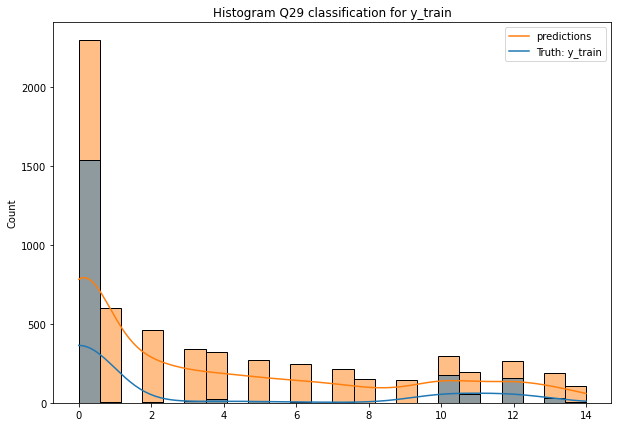

In [72]:
plt.figure(figsize=(10, 7))
sns.histplot([predictions, y_train_c], kde=True)
plt.legend(["predictions", "Truth: y_train"])
plt.title("Histogram Q29 classification for y_train")
plt.show()


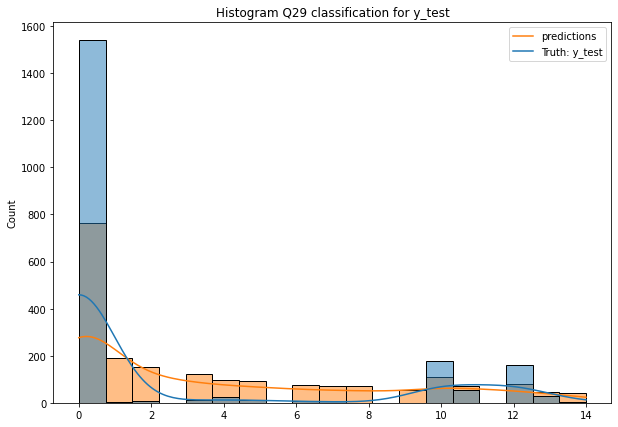

In [73]:
plt.figure(figsize=(10, 7))
sns.histplot([predictions, y_test_c], kde=True)
plt.legend(["predictions", "Truth: y_test"])
plt.title("Histogram Q29 classification for y_test")
plt.show()


In [74]:
mean_absolute_error(y_test_c, predictions) *100

240.41297935103242

In [75]:
Q29_bucket.value_counts()

0-9,999            3058
10,000-19,999       792
20,000-29,999       614
30,000-39,999       464
40,000-49,999       421
100,000-124,999     404
50,000-59,999       366
150,000-199,999     342
60,000-69,999       318
70,000-79,999       289
125,000-149,999     269
200,000-299,999     233
80,000-89,999       222
90,000-99,999       197
>300,000            147
Name: Q29_buckets, dtype: int64